In [146]:
import batman
import lmfit
import numpy as np
import matplotlib.pyplot as pl

%matplotlib notebook

Let's load the light-curve that we obtained last time

In [147]:
array = np.load("lightcurve_KELT-11.npy")
time = array[:,0]
flux = array[:,1]
flux_err = array[:,2]

<IPython.core.display.Javascript object>


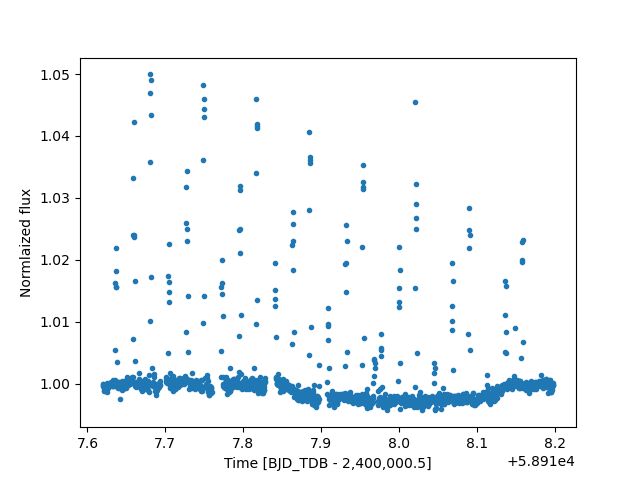

Text(0, 0.5, 'Normlaized flux')

In [155]:
fig, ax = pl.subplots()
ax.plot(time, flux, ".")
ax.set_xlabel("Time [BJD_TDB - 2,400,000.5]")
ax.set_ylabel("Normlaized flux")

On the [website of the batman package](https://lkreidberg.github.io/batman/docs/html/index.html), there is instruction on how to install it and a tutorial on how to use it to model exoplanetary transits

In [156]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 2458918.5017 - 2400000.5 + 0.01             #time of inferior conjunction
params.per = 4.736529                 #orbital period
params.rp = 0.0463                    #planet radius (in units of stellar radii)
params.a = 5.0                        #semi-major axis (in units of stellar radii)
params.inc = 85.3                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity (here I assume a circular orbit)
params.w = 90.                        #longitude of periastron (in degrees) (here I assume a circular orbit)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.1, 0.2]                 #limb darkening coefficients [u1, u2, u3, u4]

t = time  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

I initialized the model with the properties found indirectly in the [KELT-11 paper](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2009.11633.pdf) or more 

<IPython.core.display.Javascript object>


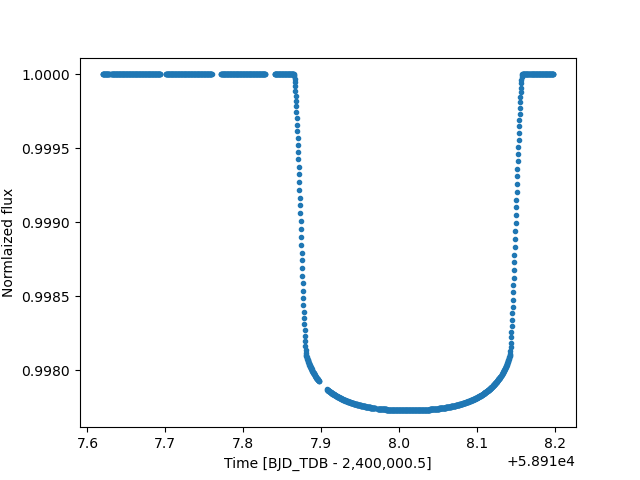

Text(0, 0.5, 'Normlaized flux')

In [157]:
fig, ax = pl.subplots()
ax.plot(t, m.light_curve(params) , ".")
ax.set_xlabel("Time [BJD_TDB - 2,400,000.5]")
ax.set_ylabel("Normlaized flux")

We can overplot both our model and or data

<IPython.core.display.Javascript object>


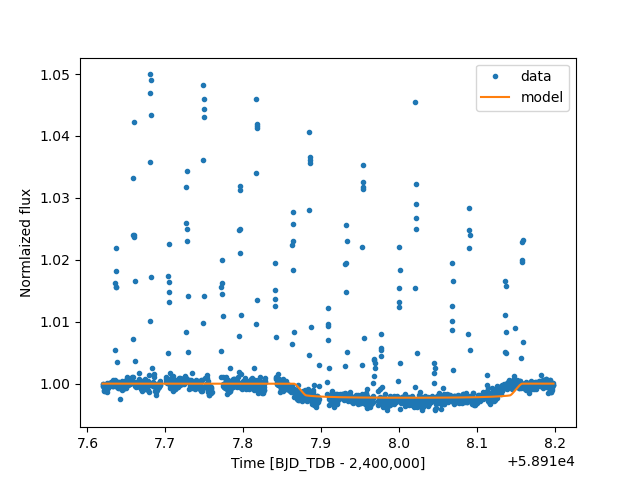

In [158]:
fig, ax = pl.subplots()
ax.plot(time, flux, ".", label="data")
ax.plot(t, m.light_curve(params) , "-", label="model")
ax.set_xlabel("Time [BJD_TDB - 2,400,000]")
ax.set_ylabel("Normlaized flux")
pl.legend()

Now let's try to fit it ! Using the [lmfit](https://lmfit.github.io/lmfit-py/index.html) package which implements multiple algorithm to fit models to data. 

In [166]:
def chi_square(param_dict, time, data, uncertainty, params):
    params.t0 = param_dict['T0']
    params.rp = param_dict['rp']
    params.inc = param_dict['inc']
    params.a = param_dict['a']
    params.u = [param_dict['u1'], param_dict['u2']]
    

    model = m.light_curve(params) + param_dict['Fout']

    return (data - model) / uncertainty

In [179]:
from lmfit import minimize, Parameters

params_lmfit = Parameters()
params_lmfit.add('T0', value=2458918.5017 - 2400000.5, vary=False)
params_lmfit.add('rp', value=0.0463 + 0.01, min=0., max=1.0)
params_lmfit.add('inc', value=85.3, min=80, max=90, vary=True)
params_lmfit.add('a', value=5., min=1, vary=True)
params_lmfit.add('Fout', value=0., min=-0.01, max=0.01)
params_lmfit.add('u1', value=0.1, vary=True)
params_lmfit.add('u2', value=0.2, vary=True)

out = minimize(chi_square, params_lmfit, args=(time, flux, flux_err, params), method="least_squares")

In [180]:
out.params

name,value,initial value,min,max,vary
T0,58918.0017,58918.001699999906,-inf,inf,False
rp,0.05109245,0.0563,0.00000000,1.00000000,True
inc,89.9500000,85.3,80.0000000,90.0000000,True
a,6.49104621,5.0,1.00000000,inf,True
Fout,0.00210740,0.0,-0.01000000,0.01000000,True
u1,-1.02478585,0.1,-inf,inf,True
u2,2.33220769,0.2,-inf,inf,True


<IPython.core.display.Javascript object>


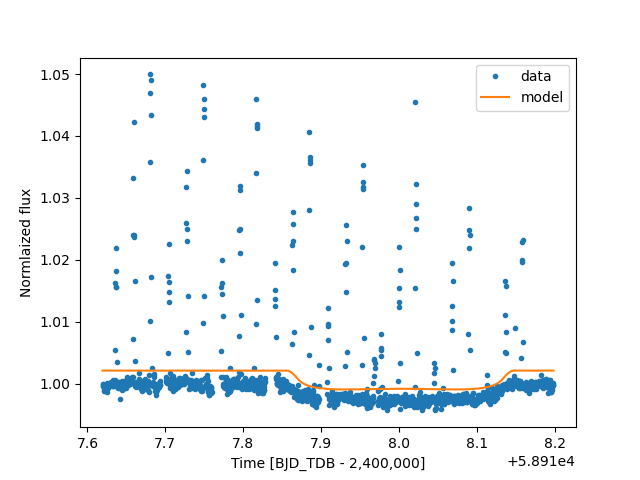

In [183]:
fig, ax = pl.subplots()
ax.plot(time, flux, ".", label="data")
ax.plot(t, m.light_curve(params) +  out.params['Fout'].value, "-", label="model")
ax.set_xlabel("Time [BJD_TDB - 2,400,000]")
ax.set_ylabel("Normlaized flux")
pl.legend()

What is the issue ?

<IPython.core.display.Javascript object>


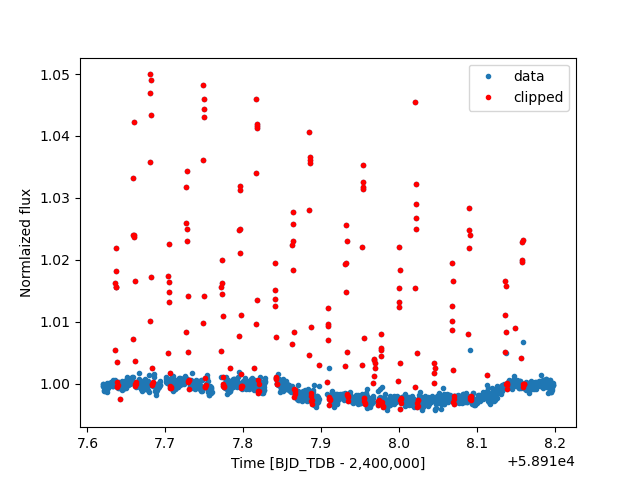

In [193]:
import pandas as pd
from astropy.stats import sigma_clip

window=10

flux_filtered = pd.Series(flux).rolling(window=window, min_periods=1).median()
flux_detrended_ma = sigma_clip(flux / flux_filtered, sigma_lower=3, sigma_upper=3)

mask = flux_detrended_ma.mask

fig, ax = pl.subplots()
ax.plot(time, flux, ".", label="data")
ax.plot(time[mask], flux[mask], '.r', label="clipped")
ax.set_xlabel("Time [BJD_TDB - 2,400,000]")
ax.set_ylabel("Normlaized flux")
pl.legend()

In [195]:
m = batman.TransitModel(params, time[~mask])    #initializes model

out = minimize(chi_square, params_lmfit, args=(time[~mask], flux[~mask], flux_err[~mask], params), method="least_squares")

In [197]:
out.params

name,value,initial value,min,max,vary
T0,58918.0017,58918.001699999906,-inf,inf,False
rp,0.04538715,0.0563,0.00000000,1.00000000,True
inc,89.9500000,85.3,80.0000000,90.0000000,True
a,5.03798700,5.0,1.00000000,inf,True
Fout,-1.4849e-04,0.0,-0.01000000,0.01000000,True
u1,0.17970863,0.1,-inf,inf,True
u2,0.86358451,0.2,-inf,inf,True


<IPython.core.display.Javascript object>


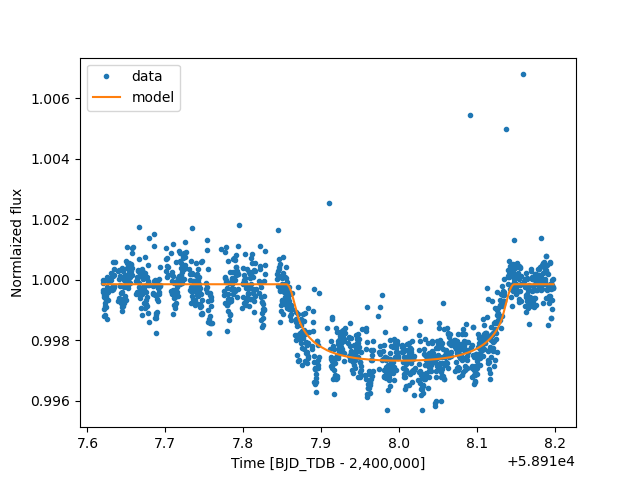

In [198]:
fig, ax = pl.subplots()
ax.plot(time[~mask], flux[~mask], ".", label="data")
ax.plot(time[~mask], m.light_curve(params) +  out.params['Fout'].value, "-", label="model")
ax.set_xlabel("Time [BJD_TDB - 2,400,000]")
ax.set_ylabel("Normlaized flux")
pl.legend()